In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datasets import *
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
from random import randint
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate
from keras.layers import Input, Reshape, Dense, Conv2D, Dropout, \
    MaxPooling2D, Flatten, UpSampling2D, Multiply, Activation, AveragePooling2D, \
    Add, Subtract, Lambda
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy.ndimage import gaussian_filter as blur
from keras.optimizers import Adam
from keras.utils import multi_gpu_model as mgpu
from keras.utils import np_utils
import os, sys

In [3]:
from models.gap import gap

model = gap(imsize=256)

 [!] Conv Spec:
 [!] 256 => 128: [64, 128]
 [!] 128 => 64: [256, 256, 256, 256]
 [!] 64 => 32: [256, 256, 256, 256]
 [!] 32 => 16: [512, 512, 512, 512]
 [!] 16 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [1024, 1024, 2048, 2048]


In [4]:
print(model.count_params())
model.compile()

102.5 million


In [5]:
dset = Tissue()

 [*] tissue_sick: 2118 unique cases
 [*] tissue_healthy: 2951 unique cases
 [*] tissue_sick: 1606 / 512
 [*] tissue_healthy: 229652 / 48912


In [10]:
counter = 0
class Preview(keras.callbacks.Callback):
    def __init__(self, evalset):
        self.evalset = evalset
        _, _, _, refs = self.evalset
        
        print('Preview set:')
        for ii in range(7):
            print('  %s' % refs[ii].split('/')[-1])
        
    def on_batch_begin(self, batch, logs={}):
        global counter
        if counter % 200 == 0:
            model.save()
            imgs, masks, lbls, refs = self.evalset
            fmaps, _ = model.saliency(imgs)
            weights = model.core.layers[-2].get_weights()[0][:, 1] # weights for 1 output

            plt.figure(figsize=(14, 4))
            for ii in range(7): # preview 7 images
                A = np.zeros((8, 8))
                for jj in range(2048):
                    A += fmaps[ii, :, :, jj] * weights[jj]
            
                plt.subplot(3, 7, ii+1)
                plt.axis('off')
                plt.imshow(imgs[ii, :, :, 0])
                plt.subplot(3, 7, 7+ii+1)
                plt.axis('off')
#                 plt.gca().set_title(np.min(A), np.max(A))
                plt.imshow(masks[ii, :, :, 0], vmin=0, vmax=1)
                plt.subplot(3, 7, 14+ii+1)
                plt.axis('off')
#                 plt.gca().set_title('%.2f~%.2f' % (np.min(A), np.max(A)))
                A -= np.min(A)
                A /= np.max(A)
                plt.imshow(A, vmin=0, vmax=1)
            plt.show()
            plt.close()
        counter += 1
        return

In [11]:
bsize=24

datagen = dset.gen(bsize=bsize,labels=['lbls'])
previewset = next(dset.gen(bsize=bsize, labels=['lbls', 'masks', 'refs'], mode='test', sickonly=True))
evalgen = dset.gen(bsize=bsize, labels=['lbls'], mode='test')

Preview set:
  01673_RIGHT_MLO.npy
  01402_RIGHT_MLO.npy
  02033_RIGHT_CC.npy
  01352_LEFT_CC.npy
  00395_RIGHT_MLO.npy
  01233_LEFT_CC.npy
  01753_RIGHT_CC.npy
Epoch 1/8


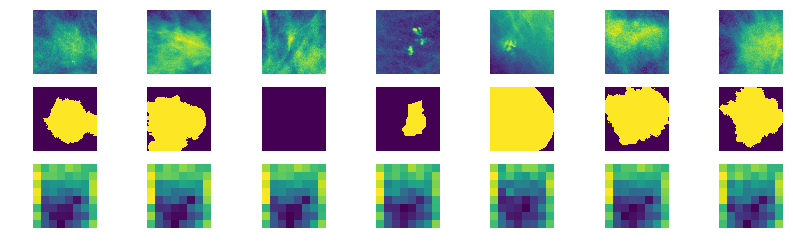

200/660 [========>.....................] - ETA: 5:00 - loss: 0.6349 - acc: 0.6996

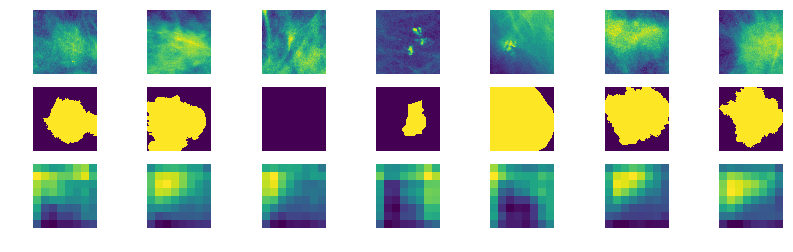

400/660 [=================>............] - ETA: 2:44 - loss: 0.5559 - acc: 0.7394

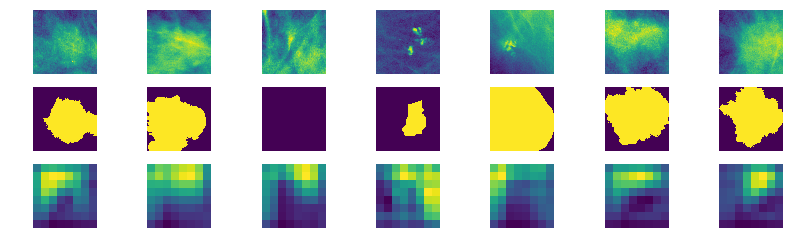

600/660 [==========================>...] - ETA: 37s - loss: 0.5305 - acc: 0.7508

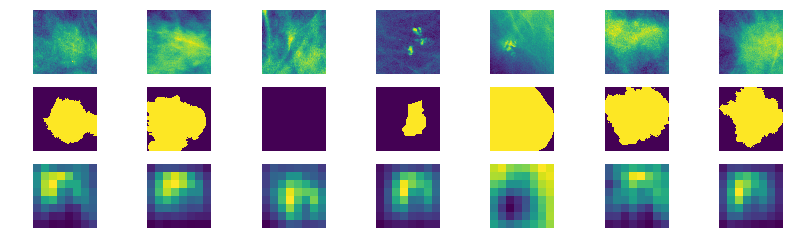

660/660 [==============================] - 417s 632ms/step - loss: 0.5248 - acc: 0.7537 - val_loss: 0.4770 - val_acc: 0.8125
Epoch 2/8
140/660 [=====>........................] - ETA: 5:16 - loss: 0.4273 - acc: 0.8062

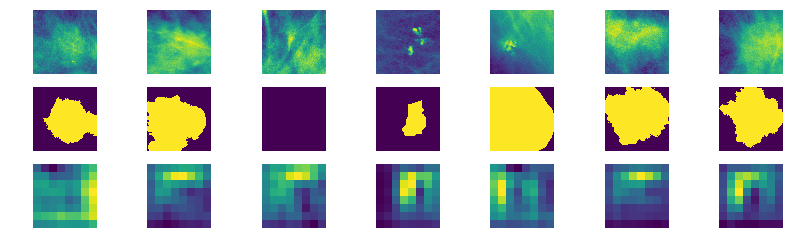

340/660 [==============>...............] - ETA: 3:16 - loss: 0.4330 - acc: 0.8033

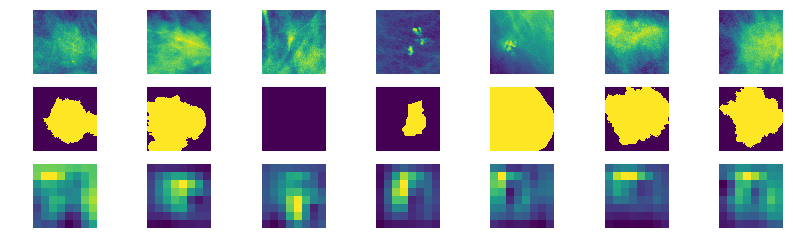

540/660 [=======================>......] - ETA: 1:13 - loss: 0.4240 - acc: 0.8109

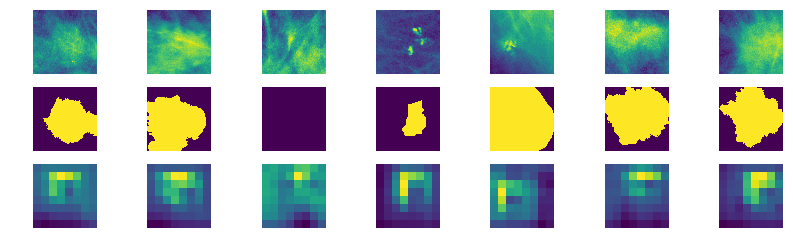

660/660 [==============================] - 408s 619ms/step - loss: 0.4169 - acc: 0.8139 - val_loss: 0.4144 - val_acc: 0.8542
Epoch 3/8
 80/660 [==>...........................] - ETA: 5:52 - loss: 0.4090 - acc: 0.8229

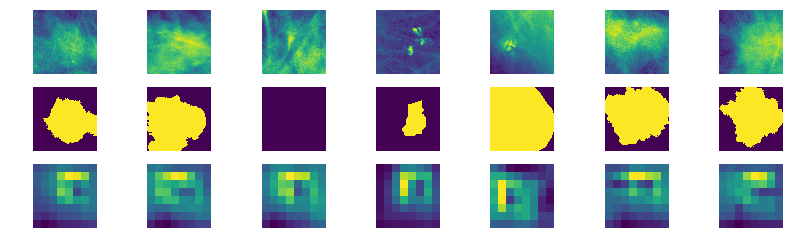

280/660 [===========>..................] - ETA: 4:46 - loss: 0.3819 - acc: 0.8362

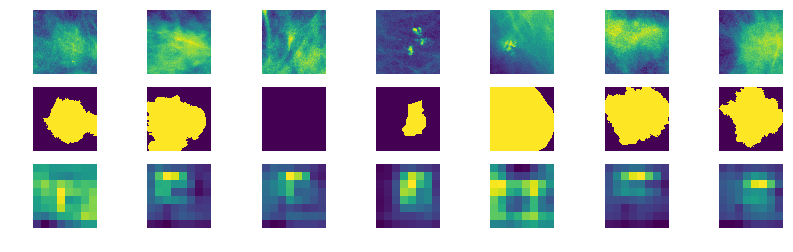

480/660 [====================>.........] - ETA: 2:23 - loss: 0.3719 - acc: 0.8411

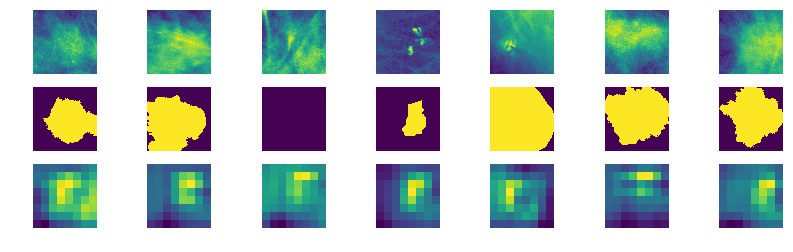

660/660 [==============================] - 537s 813ms/step - loss: 0.3669 - acc: 0.8424 - val_loss: 0.4326 - val_acc: 0.7708
Epoch 4/8
 20/660 [..............................] - ETA: 8:53 - loss: 0.3196 - acc: 0.8646

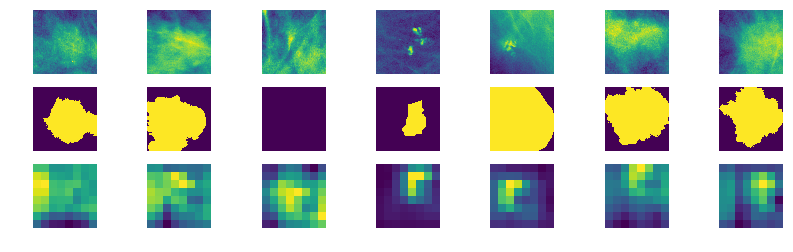

220/660 [=========>....................] - ETA: 6:43 - loss: 0.3446 - acc: 0.8532

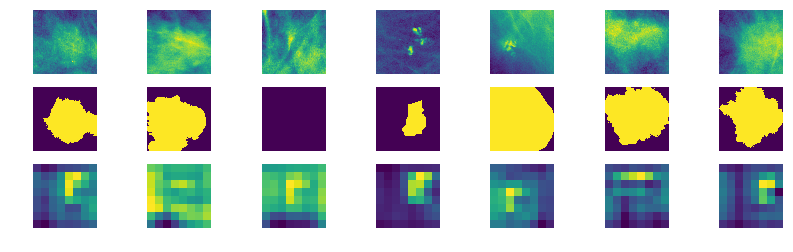

420/660 [==================>...........] - ETA: 3:33 - loss: 0.3460 - acc: 0.8540

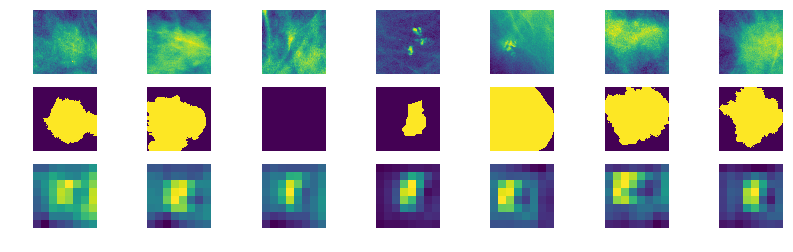

620/660 [===========================>..] - ETA: 34s - loss: 0.3419 - acc: 0.8563

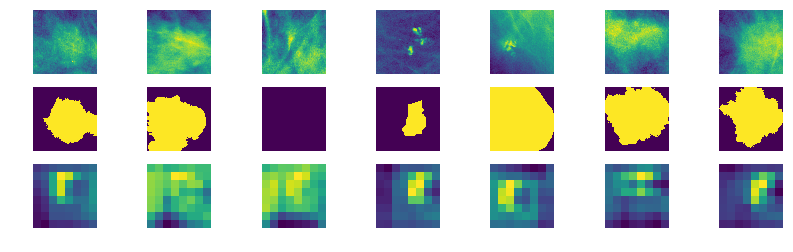

660/660 [==============================] - 570s 863ms/step - loss: 0.3400 - acc: 0.8566 - val_loss: 0.3757 - val_acc: 0.8750
Epoch 5/8
160/660 [======>.......................] - ETA: 6:31 - loss: 0.3098 - acc: 0.8682

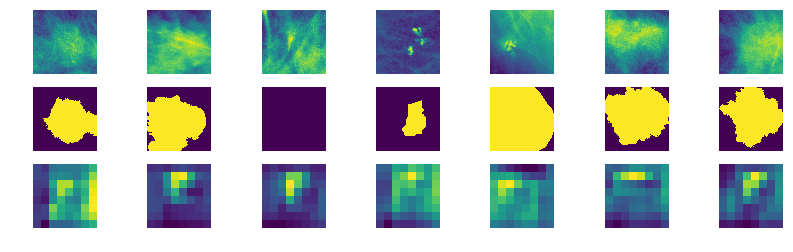

360/660 [===============>..............] - ETA: 4:09 - loss: 0.3266 - acc: 0.8620

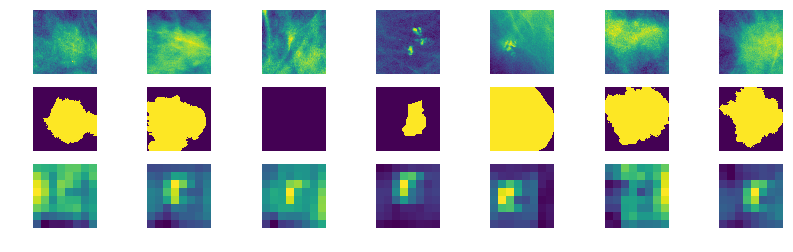

560/660 [========================>.....] - ETA: 1:23 - loss: 0.3209 - acc: 0.8661

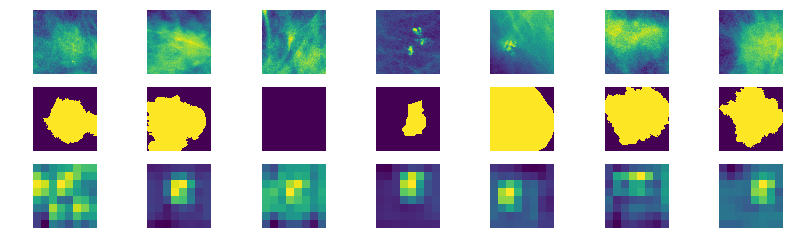

660/660 [==============================] - 548s 830ms/step - loss: 0.3200 - acc: 0.8669 - val_loss: 0.4715 - val_acc: 0.7708
Epoch 6/8
100/660 [===>..........................] - ETA: 8:07 - loss: 0.3053 - acc: 0.8679

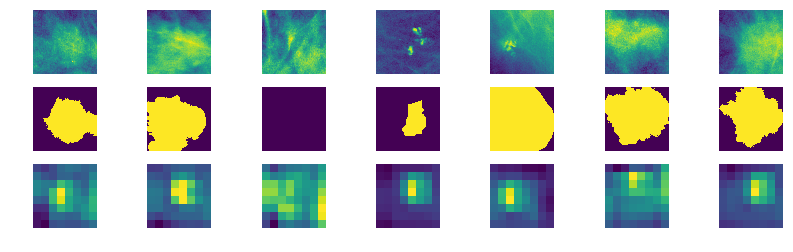

300/660 [============>.................] - ETA: 5:03 - loss: 0.3146 - acc: 0.8692

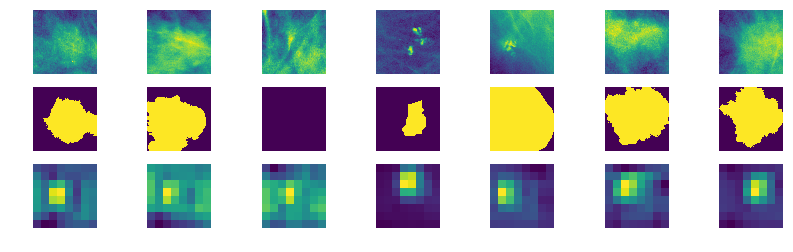

500/660 [=====================>........] - ETA: 2:12 - loss: 0.3165 - acc: 0.8691

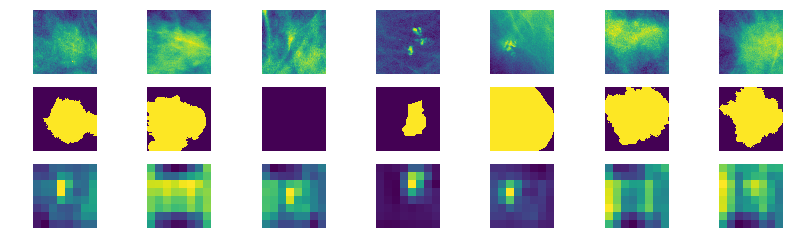

660/660 [==============================] - 533s 807ms/step - loss: 0.3160 - acc: 0.8712 - val_loss: 0.3307 - val_acc: 0.8333
Epoch 7/8
 40/660 [>.............................] - ETA: 7:28 - loss: 0.3107 - acc: 0.8708

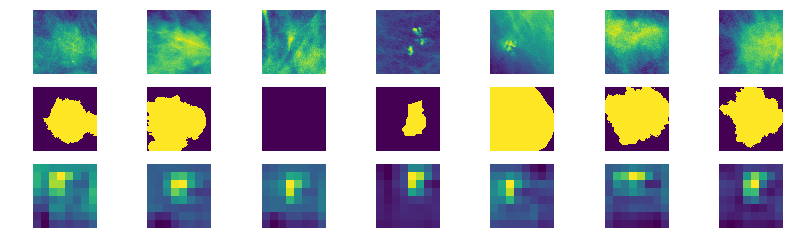

240/660 [=========>....................] - ETA: 5:37 - loss: 0.3120 - acc: 0.8694

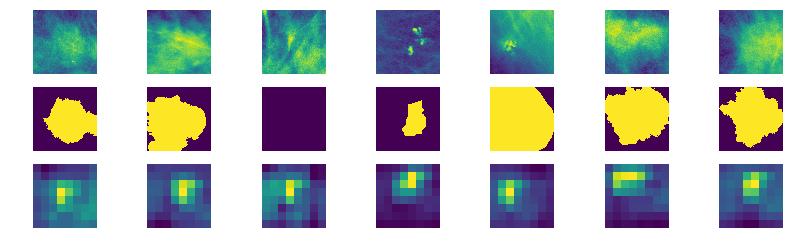

440/660 [===================>..........] - ETA: 3:01 - loss: 0.3077 - acc: 0.8702

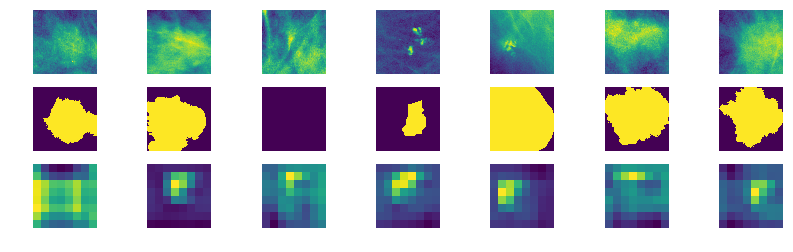

640/660 [============================>.] - ETA: 16s - loss: 0.3097 - acc: 0.8713

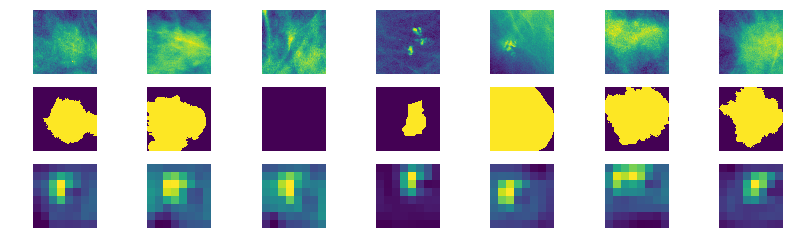

660/660 [==============================] - 546s 827ms/step - loss: 0.3098 - acc: 0.8713 - val_loss: 0.3667 - val_acc: 0.8333
Epoch 8/8
180/660 [=======>......................] - ETA: 6:16 - loss: 0.2945 - acc: 0.8778

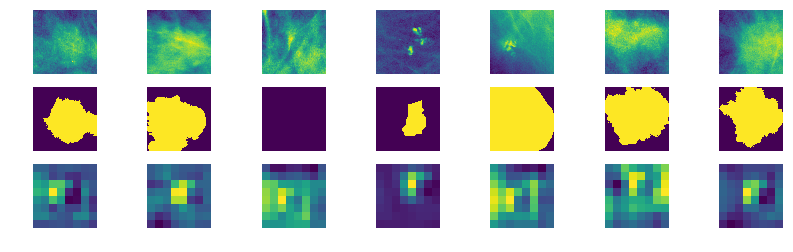

380/660 [================>.............] - ETA: 3:42 - loss: 0.2955 - acc: 0.8766

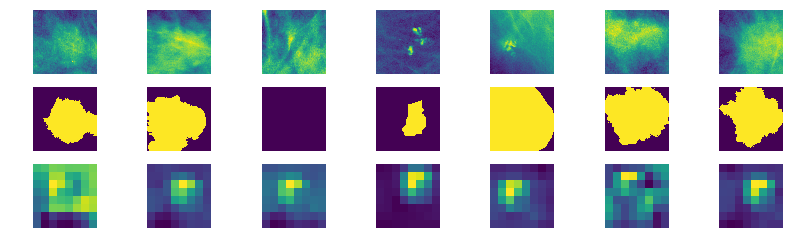

580/660 [=========================>....] - ETA: 1:04 - loss: 0.2941 - acc: 0.8798

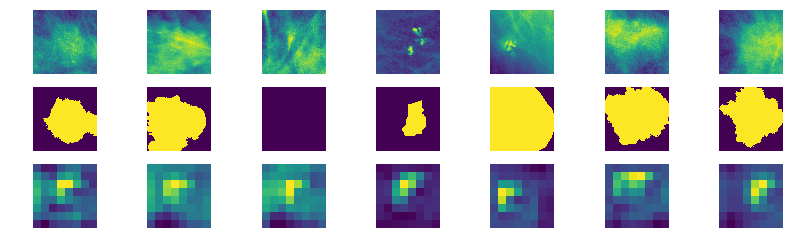

660/660 [==============================] - 533s 807ms/step - loss: 0.2932 - acc: 0.8802 - val_loss: 0.6064 - val_acc: 0.7708


In [12]:


model.model.fit_generator(
    datagen,
    epochs=8,
    verbose=1,
    steps_per_epoch=dset.train_size // bsize * 10, # do x10 to experience many augmentations
    
    validation_data=evalgen,
    validation_steps=dset.test_size // bsize // 10, # just do 10th of val data
    
    callbacks=[Preview(previewset)]
)


In [15]:


model.model.fit_generator(
    datagen,
    epochs=1,
    verbose=1,
    steps_per_epoch=1,
    
    validation_data=evalgen,
    validation_steps=dset.test_size // bsize * 10
#     callbacks=[Preview(previewset)]
)


Epoch 1/1
1/1 [==============================] - 149s 149s/step - loss: 0.2149 - acc: 0.8750 - val_loss: 0.2922 - val_acc: 0.8817
